In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

import os 
from tqdm import tqdm
import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.shape, test.shape, submission.shape

((23009, 33), (5754, 32), (5754, 2))

In [4]:
train.head(5)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부,매니저생년월일,매니저최초가입일,매니저최초서비스일,매니저성별,매니저사용휴대폰,매니저주소,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0,1956-04-19,2020-04-02,2020-06-30,0,안드로이드,서울 양천구,대중교통,서울,0.0,0.0,1,0,0
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,10:00:00,16:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-05-21,없음,NaN,NaN,0,1976-06-10,2020-10-30,2020-11-12,0,안드로이드,충남 천안시,대중교통,천안/아산,1.0,1.0,1,0,0
2,T23790,2020-11-18,NaN,1,2020-11-23,10,6,2020-12-11,9:00:00,13:00:00,1,신용카드,충남 천안시,일반주택,40평대이상,2020-10-14,없음,0.0,NaN,0,1970-04-05,2019-03-29,2019-04-04,0,안드로이드,충남 천안시,대중교통,천안/아산,0.0,0.0,0,0,0
3,T18740,2020-11-09,NaN,1,2020-11-09,4,4,2020-11-30,9:00:00,14:00:00,1,무통장입금,서울 강서구,일반주택,30평대,2020-02-06,없음,0.0,방,0,1956-04-19,2020-04-02,2020-06-30,0,안드로이드,서울 양천구,대중교통,서울,0.0,0.0,1,0,0
4,T08451,2020-02-25,NaN,1,2020-03-31,2,2,2020-04-07,9:00:00,13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-09-20,NaN,NaN,NaN,0,1966-03-24,2019-09-16,2019-09-18,0,안드로이드,충남 천안시,대중교통,천안/아산,0.0,0.0,1,0,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23009 entries, 0 to 23008
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQ         23009 non-null  object 
 1   접수일         23009 non-null  object 
 2   접수시각        3113 non-null   object 
 3   장기서비스여부     23009 non-null  int64  
 4   최초서비스일      23009 non-null  object 
 5   전체회차        23009 non-null  int64  
 6   현재회차        23009 non-null  int64  
 7   서비스일자       23009 non-null  object 
 8   서비스시작시간     23009 non-null  object 
 9   서비스종료시간     23009 non-null  object 
 10  기존고객여부      23009 non-null  int64  
 11  결재형태        23009 non-null  object 
 12  서비스주소       23009 non-null  object 
 13  주거형태        23009 non-null  object 
 14  평수          13856 non-null  object 
 15  고객가입일       23009 non-null  object 
 16  반려동물        20234 non-null  object 
 17  부재중여부       13856 non-null  float64
 18  우선청소        10979 non-null  object 
 19  쿠폰사용여부      23009 non-nul

In [6]:
submission.head()

,SEQ,pred
0,T02974,0
1,T01495,0
2,T24344,0
3,T01825,0
4,T21915,0


## 기본 전처리 및 feature 생성

In [7]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일'])
train['매니저최초가입일'] = pd.to_datetime(train['매니저최초가입일'])
train['매니저최초서비스일'] = pd.to_datetime(train['매니저최초서비스일'])

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간2'] = train['서비스시작시간'].dt.hour
train['서비스종료시간2'] = train['서비스종료시간'].dt.hour

train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
train['접수후걸린시일'] = train['최초서비스일'] - train['접수일']
train['회차사용비율'] = train['현재회차'] / train['전체회차']

In [8]:
# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])
test['매니저최초가입일'] = pd.to_datetime(test['매니저최초가입일'])
test['매니저최초서비스일'] = pd.to_datetime(test['매니저최초서비스일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간2'] = test['서비스시작시간'].dt.hour
test['서비스종료시간2'] = test['서비스종료시간'].dt.hour

test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']
test['접수후걸린시일'] = test['최초서비스일'] - test['접수일']
test['회차사용비율'] = test['현재회차'] / test['전체회차']

In [9]:
# 고객과 매니저의 짬 차이
train['고객_매니저_짬차이'] = train['고객가입일'] - train['매니저최초가입일']
train['고객짬>매니저짬여부'] = (train['고객_매니저_짬차이'] > '0days').astype(int)

test['고객_매니저_짬차이'] = test['고객가입일'] - test['매니저최초가입일']
test['고객짬>매니저짬여부'] = (test['고객_매니저_짬차이'] > '0days').astype(int)

In [10]:
# 접수일 기준 매니저 짬
train['접수일기준_매니저짬'] = train['접수일'] - train['매니저최초서비스일']
test['접수일기준_매니저짬'] = test['접수일'] - test['매니저최초서비스일']

In [11]:
# timedelta 형식 feature -> int형식으로
train['접수후걸린시일'] = train['접수후걸린시일'].dt.days.astype('int16')
train['고객_매니저_짬차이'] = train['고객_매니저_짬차이'].dt.days.astype('int16')
train['접수일기준_매니저짬'] = train['접수일기준_매니저짬'].dt.days.astype('int16')
train['서비스소요시간'] = train['서비스소요시간'].dt.seconds.astype('int32') // 3600

test['접수후걸린시일'] = test['접수후걸린시일'].dt.days.astype('int16')
test['고객_매니저_짬차이'] = test['고객_매니저_짬차이'].dt.days.astype('int16')
test['접수일기준_매니저짬'] = test['접수일기준_매니저짬'].dt.days.astype('int16')
test['서비스소요시간'] = test['서비스소요시간'].dt.seconds.astype('int32') // 3600

In [12]:
# 시간 추가 여부
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)

In [13]:
# sin, cos encoding 월/주/일까지 적용
#train['sin_서비스시작시간'] = np.sin(2*np.pi*train['서비스시작시간2']/24)
#train['cos_서비스시작시간'] = np.cos(2*np.pi*train['서비스시작시간2']/24)
#train['sin_서비스종료시간'] = np.sin(2*np.pi*train['서비스종료시간2']/24)
#train['cos_서비스종료시간'] = np.cos(2*np.pi*train['서비스종료시간2']/24)

#test['sin_서비스시작시간'] = np.sin(2*np.pi*test['서비스시작시간2']/24)
#test['cos_서비스시작시간'] = np.cos(2*np.pi*test['서비스시작시간2']/24)
#test['sin_서비스종료시간'] = np.sin(2*np.pi*test['서비스종료시간2']/24)
#test['cos_서비스종료시간'] = np.cos(2*np.pi*test['서비스종료시간2']/24)

In [13]:
# 매니저 근속일수
train['매니저_근속일수'] = train['서비스일자'].max() - train['매니저최초가입일']
train['매니저_근속일수'] = train['매니저_근속일수'].apply(lambda x : x.days)

test['매니저_근속일수'] = test['서비스일자'].max() - test['매니저최초가입일']
test['매니저_근속일수'] = test['매니저_근속일수'].apply(lambda x : x.days)

In [14]:
# 매니저 최초대기일수
train['매니저_최초대기일수'] = train['매니저최초서비스일'] - train['매니저최초가입일']
train['매니저_최초대기일수'] = train['매니저_최초대기일수'].apply(lambda x : x.days)

test['매니저_최초대기일수'] = test['매니저최초서비스일'] - test['매니저최초가입일']
test['매니저_최초대기일수'] = test['매니저_최초대기일수'].apply(lambda x : x.days)

In [15]:
# 매니저 나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x.year)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x.year)

## 데이터 셋 세팅

In [16]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저최초가입일', '매니저최초서비스일',
       '매니저성별', '매니저사용휴대폰', '매니저주소', '매니저이동방법', '근무가능지역', 'CS교육이수여부',
       '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '매칭성공여부', '서비스시작시간2', '서비스종료시간2',
       '서비스소요시간', '접수후걸린시일', '회차사용비율', '고객_매니저_짬차이', '고객짬>매니저짬여부',
       '접수일기준_매니저짬', '시간추가여부', '매니저_근속일수', '매니저_최초대기일수', '매니저나이'],
      dtype='object')

In [17]:
features = ['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', 
            '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저주소', '매니저이동방법', '근무가능지역', 
            'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스소요시간', '접수후걸린시일', 
            '회차사용비율', '고객_매니저_짬차이', '고객짬>매니저짬여부', '접수일기준_매니저짬', '시간추가여부',
            '매니저_근속일수', '매니저_최초대기일수', '매니저나이']

In [18]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [19]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물', '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [20]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['결재형태', '서비스주소', '주거형태', '평수', '반려동물', '우선청소', '매니저사용휴대폰', 
       '매니저주소', '매니저이동방법', '근무가능지역']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [21]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저주소', '매니저이동방법', '근무가능지역', 'CS교육이수여부', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '고객짬>매니저짬여부', '시간추가여부']

In [22]:
cat_lst = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 24, 26]

In [23]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


In [24]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

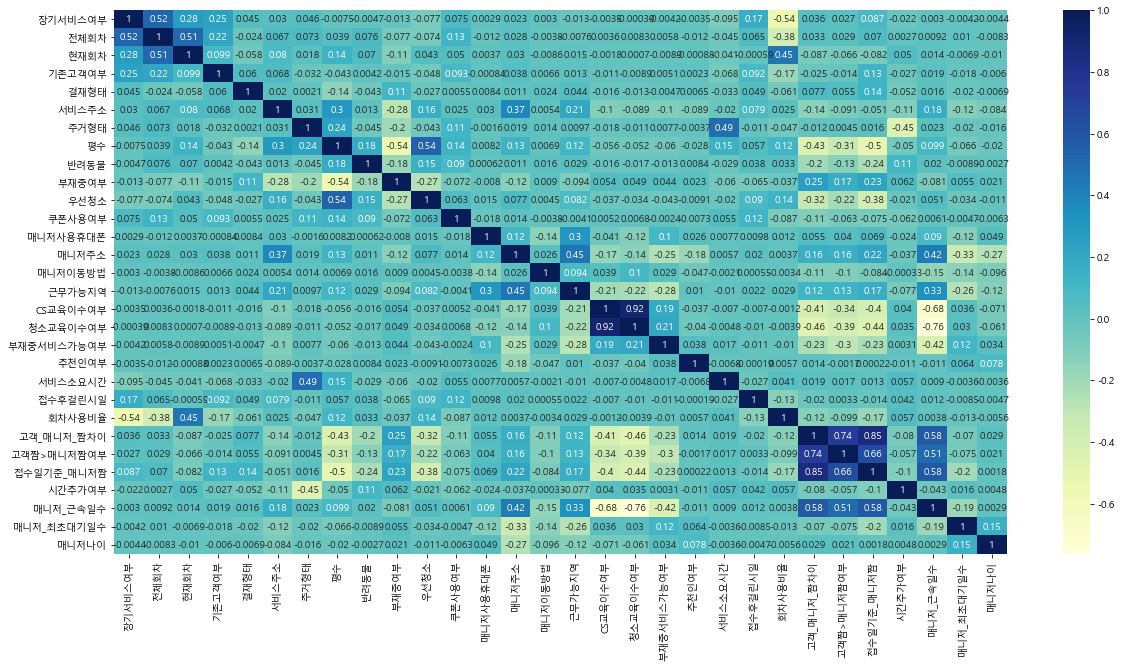

In [25]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

### Min-max

In [26]:
num_features = list(set(ftr.columns) - set(cat_features))

In [27]:
num_features

['매니저_근속일수',
 '접수일기준_매니저짬',
 '접수후걸린시일',
 '서비스소요시간',
 '고객_매니저_짬차이',
 '회차사용비율',
 '매니저나이',
 '현재회차',
 '전체회차',
 '매니저_최초대기일수']

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

## 샘플링

### over sampling

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
# SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(ftr_imputed, target)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', ftr_imputed.shape, target.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (23009, 30) (23009,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (41622, 30) (41622,)
SMOTE 적용 후 레이블 값 분포: 
 0    20811
1    20811
Name: 매칭성공여부, dtype: int64


In [79]:
ftr_imputed = X_train_over
target = y_train_over

In [34]:
# 문제는 특이 치에있을 수 있습니다. 앞서 언급했듯이 ADASYN은 밀도가 낮은 밀도 데이터에 중점을 둡니다. 
# 종종 저밀도 데이터는 특이 치입니다. 그런 다음 ADASYN 접근 방식은 피쳐 공간의 이러한 영역에 너무 많은주의를 기울여 
# 모델 성능을 저하시킬 수 있습니다. ADASYN을 사용하기 전에 이상 값을 제거하는 것이 좋습니다.
from imblearn.over_sampling import *
X_samp, y_samp = ADASYN(random_state=0, sampling_strategy='minority').fit_sample(ftr_imputed, target)

In [35]:
X_samp.shape, y_samp.shape

((41204, 30), (41204,))

### combine sampling

## 모델링

In [29]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
def get_f15_score(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f15 = ((1+1.5**2) * precision * recall) / ((1.5**2)*precision + recall)
    return f15

In [31]:
kf = StratifiedKFold(n_splits=15, random_state=0, shuffle=True)

In [32]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', 
                '쿠폰사용여부', '매니저사용휴대폰', '매니저주소', '매니저이동방법', '근무가능지역', 'CS교육이수여부', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '고객짬>매니저짬여부', '시간추가여부']

In [33]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 30), (23009,), (5754, 30))

### Catboost

In [59]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [60]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [61]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [62]:
cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='Logloss', class_weights=class_weights,
                        silent=True, loss_function='Logloss')

In [63]:
cb_pred = np.zeros((ftr_te.shape[0]))
f15_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end=best)
    f15 = get_f15_score(val_y, pred)
    f15_list.append(f15)
    print(f'FOLD f15 = {f15}')
    sub_pred = cb.predict(ftr_te_imputed, ntree_end=best) / 15
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} F1.5_score = {np.mean(f15_list)}')

0:	learn: 0.6885671	test: 0.6883677	best: 0.6883677 (0)	total: 194ms	remaining: 32m 20s
2000:	learn: 0.1014956	test: 0.1296469	best: 0.1296469 (2000)	total: 2m 13s	remaining: 8m 54s
4000:	learn: 0.0398843	test: 0.0811957	best: 0.0811957 (4000)	total: 4m 40s	remaining: 6m 59s
6000:	learn: 0.0215084	test: 0.0705226	best: 0.0703201 (5925)	total: 7m	remaining: 4m 40s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.06930700207
bestIteration = 6884

Shrink model to first 6885 iterations.
FOLD f15 = 0.9664921465968586
0:	learn: 0.6885512	test: 0.6884981	best: 0.6884981 (0)	total: 51.8ms	remaining: 8m 38s
2000:	learn: 0.1049683	test: 0.1547960	best: 0.1547960 (2000)	total: 2m 32s	remaining: 10m 10s
4000:	learn: 0.0415643	test: 0.1173048	best: 0.1173048 (4000)	total: 4m 42s	remaining: 7m 3s
6000:	learn: 0.0218638	test: 0.1146969	best: 0.1144983 (5264)	total: 6m 50s	remaining: 4m 33s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.1144885386
bestIterat

4000:	learn: 0.0408556	test: 0.1073279	best: 0.1072805 (3992)	total: 4m 35s	remaining: 6m 53s
6000:	learn: 0.0220008	test: 0.1000747	best: 0.0999079 (5588)	total: 6m 47s	remaining: 4m 31s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.09943656477
bestIteration = 6308

Shrink model to first 6309 iterations.
FOLD f15 = 0.9432176656151419

CatBoostClassifier F1.5_score = 0.9479041494094261


In [64]:
cb_pred.shape

(5754,)

In [65]:
cb_pred

array([0., 1., 0., ..., 0., 0., 0.])

### LightGBM

In [34]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype('category')
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype('category')

In [35]:
lgb = LGBMClassifier(random_state=0, max_depth=16, n_estimators=20000, learning_rate=0.01, 
                     boost_from_average=True, is_unbalance=True)

In [36]:
lgb_pred = np.zeros((ftr_te.shape[0]))
f15_list = []
for tr_idx, val_idx in kf.split(ftr_imputed.values, target):
    tr_x, val_x = ftr_imputed.values[tr_idx], ftr_imputed.values[val_idx]
    tr_y, val_y = target[tr_idx], target[val_idx]
    lgb.fit(tr_x, tr_y, eval_set=[(tr_x, tr_y), (val_x, val_y)], eval_metric='F1', early_stopping_rounds=2000, 
             verbose=2000)
    pred = lgb.predict(val_x)
    f15 = get_f15_score(val_y, pred)
    f15_list.append(f15)
    print(f'FOLD f15 = {f15}')
    sub_pred = lgb.predict(ftr_te_imputed) / 15
    lgb_pred += sub_pred
print(f'\n{lgb.__class__.__name__} F1.5_score = {np.mean(f15_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.125162	valid_1's binary_logloss: 0.152483
[4000]	training's binary_logloss: 0.0499748	valid_1's binary_logloss: 0.0876148
[6000]	training's binary_logloss: 0.0215042	valid_1's binary_logloss: 0.0616348
[8000]	training's binary_logloss: 0.00968783	valid_1's binary_logloss: 0.050634
[10000]	training's binary_logloss: 0.00447834	valid_1's binary_logloss: 0.0473461
[12000]	training's binary_logloss: 0.00204058	valid_1's binary_logloss: 0.0470732
[14000]	training's binary_logloss: 0.000920602	valid_1's binary_logloss: 0.0471331
Early stopping, best iteration is:
[13230]	training's binary_logloss: 0.00124444	valid_1's binary_logloss: 0.0462519
FOLD f15 = 0.9492063492063494
Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.122311	valid_1's binary_logloss: 0.154223
[4000]	training's binary_logloss: 0.0496469	valid_1's binary_logloss: 0.0928314
[600

Early stopping, best iteration is:
[9378]	training's binary_logloss: 0.00522879	valid_1's binary_logloss: 0.0616468
FOLD f15 = 0.8930256948086001
Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.116786	valid_1's binary_logloss: 0.161577
[4000]	training's binary_logloss: 0.0470472	valid_1's binary_logloss: 0.10769
[6000]	training's binary_logloss: 0.0208426	valid_1's binary_logloss: 0.0900808
[8000]	training's binary_logloss: 0.00892937	valid_1's binary_logloss: 0.0836904
[10000]	training's binary_logloss: 0.00394765	valid_1's binary_logloss: 0.0823051
[12000]	training's binary_logloss: 0.00173735	valid_1's binary_logloss: 0.0854282
Early stopping, best iteration is:
[10107]	training's binary_logloss: 0.00379428	valid_1's binary_logloss: 0.0821645
FOLD f15 = 0.8607461902259589
Training until validation scores don't improve for 2000 rounds
[2000]	training's binary_logloss: 0.123164	valid_1's binary_logloss: 0.157143
[4000]	training's bina

In [37]:
lgb_pred.shape

(5754,)

In [38]:
lgb_pred

array([0., 1., 0., ..., 0., 0., 0.])

## submission

In [39]:
submission['pred'] = (lgb_pred)

In [40]:
submission['pred'] = submission['pred'].apply(lambda x : 1 if x >= 0.5 else 0)

In [41]:
submission['pred'].value_counts()

0    5209
1     545
Name: pred, dtype: int64

In [42]:
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T02974,0
T01495,1
T24344,0
T01825,0
T21915,0
...,...
T02686,0
T06003,0
T23943,0


In [79]:
submission.to_csv('submission/1114_lgb_mm_pyeong.csv')